# Data frame operations with SparkSQL and SparkR

[**Introduction to Apache Spark with R by J. A. Dianes**](https://github.com/jadianes/spark-r-notebooks)

In this notebook we will introduce more advanced concepts about SparkSQL with R that you can find in the [SparkR documentation](http://spark.apache.org/docs/latest/sparkr.html), applied to the [2013 American Community Survey](http://www.census.gov/programs-surveys/acs/data/summary-file.html) housing data. These concepts are related with data frame manipulation, including data slicing, summary statistics, and aggregations. We will use them in combination with [ggplot2](http://ggplot2.org/) visualisations. We will explain what we do at every step but, if you want to go deeper into `ggplot2` for exploratory data analysis, I did this [Udacity on-line course](https://www.udacity.com/course/data-analysis-with-r--ud651) in the past and I highly recommend it!  

## Creating a SparkSQL context and loading data

In order to explore our data, we first need to load it into a SparkSQL data frame. But first we need to init a SparkSQL context. The first thing we need to do is to set up some environment variables and library paths as follows. Remember to replace the value assigned to `SPARK_HOME` with your Spark home folder.  

In [1]:
# Set Spark home and R libs
library(SparkR, lib.loc = c(file.path(Sys.getenv("SPARK_HOME"), "R", "lib")))


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union



Now we can load the `SparkR` library as follows.

In [2]:
sqlContext <- sparkR.session(master = "local[*]", sparkConfig = list(spark.driver.memory = "2g") ,sparkPackages = "com.databricks:spark-csv_2.11:1.2.0")


Spark package found in SPARK_HOME: /opt/spark


Launching java with spark-submit command /opt/spark/bin/spark-submit  --packages com.databricks:spark-csv_2.11:1.2.0 --driver-memory "2g" sparkr-shell /tmp/RtmpC75qE9/backend_port313636ef9739 


And now we can initialise the Spark context as [in the official documentation](http://spark.apache.org/docs/latest/sparkr.html#starting-up-sparkcontext-sqlcontext). In our case we are use a standalone Spark cluster with one master and seven workers. If you are running Spark in local node, use just `master='local'`. Additionally, we require a Spark package from Databricks to read CSV files (more on this in the [previous notebook](https://github.com/jadianes/spark-r-notebooks/blob/master/notebooks/nb1-spark-sql-basics/nb1-spark-sql-basics.ipynb)). 

In [3]:
# sc <- sparkR.init(master='spark://169.254.206.2:7077', sparkPackages="com.databricks:spark-csv_2.11:1.2.0")

And finally we can start the SparkSQL context as follows.

In [4]:
# sqlContext <- sparkRSQL.init(sc)

Now that we have our SparkSQL context ready, we can use it to load our CSV data into data frames. We have downloaded our [2013 American Community Survey dataset](http://www.census.gov/programs-surveys/acs/data/summary-file.html) files in [notebook 0](https://github.com/jadianes/spark-r-notebooks/tree/master/notebooks/nb0-starting-up/nb0-starting-up.ipynb), so they should be stored locally. Remember to set the right path for your data files in the first line, ours is `/nfs/data/2013-acs/ss13husa.csv`.  

In [5]:
housing_a_file_path <- file.path('', 'home','spark','pu_workshop','data','2013-acs','ss13husa.csv')
housing_b_file_path <- file.path('', 'home','spark','pu_workshop','data','2013-acs','ss13husa.csv')

Now let's read into a SparkSQL dataframe. We need to pass four parameters in addition to the `sqlContext`:  

- The file path.  
- `header='true'` since our `csv` files have a header with the column names. 
- Indicate that we want the library to infer the schema.  
- And the source type (the Databricks package in this case). 

And we have two separate files for both, housing and population data. We need to join them.

In [6]:
housing_a_df <- read.df(
    #sqlContext, 
                        housing_a_file_path, 
                        header='true', 
                        source = "com.databricks.spark.csv", 
                        inferSchema='true')

In [7]:
housing_b_df <- read.df(
    #sqlContext, 
                        housing_b_file_path, 
                        header='true', 
                        source = "com.databricks.spark.csv", 
                        inferSchema='true')

In [8]:
housing_df <- rbind(housing_a_df, housing_b_df)

Let's check that we have everything there by counting the files and listing a few of them.

In [9]:
nrow(housing_df)

[1] 1512130

In [10]:
head(housing_df)

RT SERIALNO DIVISION PUMA REGION ST ADJHSG  ADJINC  WGTP NP ⋯ wgtp71 wgtp72
1 H   84      6        2600 3      1  1000000 1007549   0  1  ⋯   0      0   
2 H  154      6        2500 3      1  1000000 1007549  51  4  ⋯  86     53   
3 H  156      6        1700 3      1  1000000 1007549 449  1  ⋯ 161    530   
4 H  160      6        2200 3      1  1000000 1007549  16  3  ⋯  31     24   
5 H  231      6        2400 3      1  1000000 1007549  52  1  ⋯  21     18   
6 H  286      6         900 3      1  1000000 1007549  76  1  ⋯ 128     25   
  wgtp73 wgtp74 wgtp75 wgtp76 wgtp77 wgtp78 wgtp79 wgtp80
1   0      0      0      0      0      0      0      0   
2  59     84     49     15     15     20     50     16   
3 601    579    341    378    387    421    621    486   
4  33      7      7     13     18     23     23      5   
5  37     49    103     38     49     51     46     47   
6  68     66     80     26     66    164     88     24

## Giving ggplot2 a try

Before we dive into data selection and aggregations, let's try plotting something using [ggplot2](http://ggplot2.org). We will use this library all the time during our exploratory data analysis, and we better mke sure how to use it with SparkSQL results.

In [11]:
# if it isn't installed, 
# install install.packages("ggplot2") 
# from the R console, specifying a CRAN mirror

library(ggplot2)

What if we directly try to use our SparkSQL `DataFrame` class into a `ggplot`?

In [12]:
c <- ggplot(data=housing_df, aes(x=factor(REGION)))

ERROR: Error: ggplot2 doesn't know how to deal with data of class SparkDataFrame


Obviously it doesn't work that way. The `ggplot` function doesn't know how to deal with that type of distributed data frames (the Spark ones). Instead, we need to collect the data locally as follows.

In [13]:
housing_region_df_local <- collect(select(housing_df,"REGION"))

Let's have a look at what we got.

In [14]:
str(housing_region_df_local)

'data.frame':	1512130 obs. of  1 variable:
 $ REGION: int  3 3 3 3 3 3 3 3 3 3 ...


That is, when we collect results from a SparkSQL `DataFrame` we get a regular R `data.frame`. Very convenient since we can manipulate it as we need to. For example, let's convert that `int` values we have for `REGION` to a factor with the proper names. From our [data dictionary](http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict13.txt) we will get the meaning of the `REGION` variable, as well as the different values it can take.

In [15]:
housing_region_df_local$REGION <- factor(
    x=housing_region_df_local$REGION, 
    levels=c(1,2,3,4,9),
    labels=c('Northeast', 'Midwest','South','West','Puerto Rico')
)

And now we are ready to create the ggplot object as follows.

In [16]:
c <- ggplot(data=housing_region_df_local, aes(x=factor(REGION)))

And now we can give the plot a proper representation (e.g. a [bar plot](http://docs.ggplot2.org/current/geom_bar.html)). 

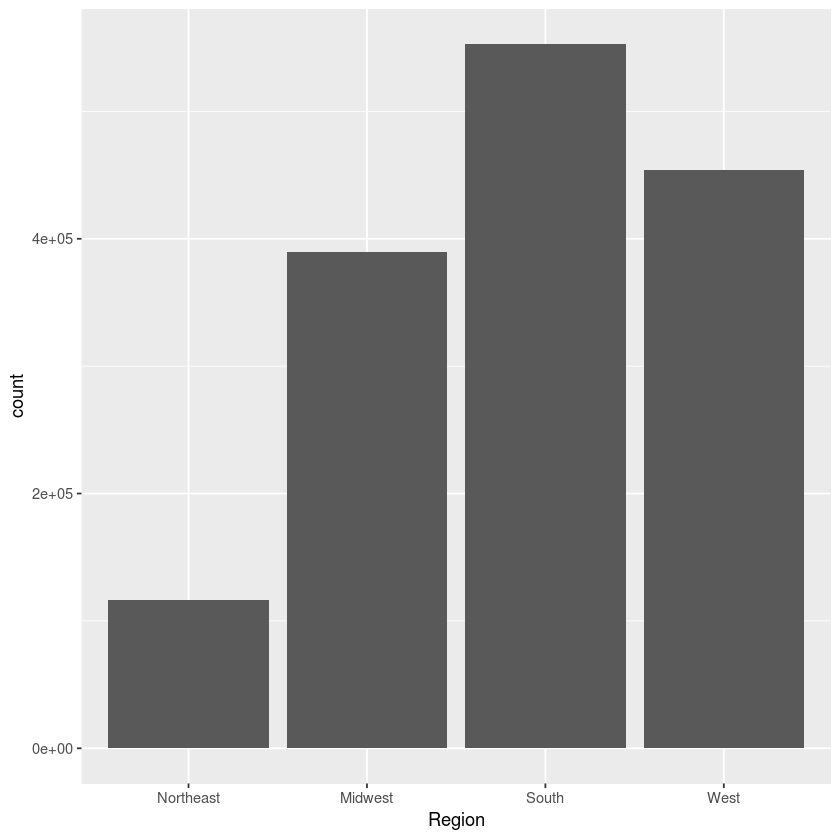

In [17]:
c + geom_bar() + xlab("Region")

We will always follow the same approach. First we make some sort of oepration with the SparkSQL `DataFrame` object (e.g. a selection), then we collect results, and then we prepare the resulting `data.frame` to be represented using ggplot2. But think about the previous. We just represented all the samples for a given column. That is almost a million and a half data points, and we are pushing our local R environment and ggplot2 a lot. In the case of the bar plot we didn't really experience any problems, cause is sort of aggregating data inside. But we will struggle to do scatter plots this way. The preferred kind of visualisations will be those that come from data from aggreations on SparkSQL `DataFrames` as we will see in further sections.

## Data selection

In this section we will demonstrate how to select data from a SparkSQL `DataFrame` object using SparkR. 

### `select` and `selectExpr`

We already made use of the `select` function. but let's have a look at the documentation.

In [18]:
?select

We have two flavours of `select`. One that gets a list of column names (this is the one we used so far) and another one called `selectExpr` that we pass a string containing a SQL expression. 

Of course we can pass more than a column name.

In [19]:
collect(select(housing_df, "REGION", "VALP"))

REGION VALP  
1       3          NA
2       3       25000
3       3       80000
4       3          NA
5       3          NA
6       3       18000
7       3      390000
8       3      120000
9       3          NA
10      3      160000
11      3          NA
12      3          NA
13      3          NA
14      3          NA
15      3       40000
16      3       60000
17      3       60000
18      3          NA
19      3      250000
20      3      110000
21      3      190000
22      3      160000
23      3          NA
24      3      750000
25      3      300000
26      3          NA
27      3          NA
28      3      100000
29      3       20000
30      3       70000
⋮       ⋮      ⋮     
1512101 3          NA
1512102 3          NA
1512103 3       80000
1512104 3          NA
1512105 3          NA
1512106 3          NA
1512107 3        2000
1512108 3      130000
1512109 3      185000
1512110 3       40000
1512111 3          NA
1512112 3      135000
1512113 3          NA
1512114 3       80000
1512115 3       40000
1512116 3       45000
1512117 3       75000
1512118 3       70000
1512119 3       56000
1512120 3       80000
1512121 3       40000
1512122 3       90000
1512123 3      300000
1512124 3      250000
1512125 3          NA
1512126 3      180000
1512127 3       30000
1512128 3          NA
1512129 3          NA
1512130 3      164000

When passing column names we can also use the R notation `data.frame$column.name` so familiar to R users. For example.

In [20]:
collect(select(housing_df, housing_df$VALP))

VALP  
1           NA
2        25000
3        80000
4           NA
5           NA
6        18000
7       390000
8       120000
9           NA
10      160000
11          NA
12          NA
13          NA
14          NA
15       40000
16       60000
17       60000
18          NA
19      250000
20      110000
21      190000
22      160000
23          NA
24      750000
25      300000
26          NA
27          NA
28      100000
29       20000
30       70000
⋮       ⋮     
1512101     NA
1512102     NA
1512103  80000
1512104     NA
1512105     NA
1512106     NA
1512107   2000
1512108 130000
1512109 185000
1512110  40000
1512111     NA
1512112 135000
1512113     NA
1512114  80000
1512115  40000
1512116  45000
1512117  75000
1512118  70000
1512119  56000
1512120  80000
1512121  40000
1512122  90000
1512123 300000
1512124 250000
1512125     NA
1512126 180000
1512127  30000
1512128     NA
1512129     NA
1512130 164000

How does this notation compares to the name-based one in terms of performance?

In [22]:
system.time(
    collect(select(housing_df, housing_df$VALP))
)

   user  system elapsed 
 24.585   0.920  36.632 

In [22]:
system.time(
    collect(select(housing_df, "VALP"))
)

   user  system elapsed 
 28.766   0.012  46.358 

When using the $ notation, we can even pass expressions as follows.

In [23]:
head(select(housing_df, housing_df$VALP / 100))

(VALP / 100.0)
1             NA
2            250
3            800
4             NA
5             NA
6            180

So what's the point of `selectExpr` then? Well, we can pass more complex SQL expressions. For example.

In [24]:
head(selectExpr(housing_df, "(VALP / 100) as VALP_by_100"))

VALP_by_100
1          NA
2         250
3         800
4          NA
5          NA
6         180

### `filter`, `subset`, and `sql`

The previous functions allow us selecting columns. In order to select rows, we will use `filter` and `contains`.

In [21]:
?filter

With `filter` we filter the rows of a DataFrame according to a given condition that we pass as argument. We can define conditions as SQL conditions using column names or by using the $ notation.

For example, and following with our property values column, let's select property values higher than 1000 for the south region.

In [26]:
system.time(
    housing_valp_1000 <- collect(filter(select(housing_df, "REGION", "VALP"), "VALP > 1000"))
)

   user  system elapsed 
 38.043   0.184  56.259 

In [27]:
housing_valp_1000

REGION    VALP
1           3   25000
2           3   80000
3           3   18000
4           3  390000
5           3  120000
6           3  160000
7           3   40000
8           3   60000
9           3   60000
10          3  250000
11          3  110000
12          3  190000
13          3  160000
14          3  750000
15          3  300000
16          3  100000
17          3   20000
18          3   70000
19          3  125000
20          3 1843000
21          3  829000
22          3   84000
23          3  150000
24          3  130000
25          3   90000
26          3  220000
27          3  225000
28          3   65000
29          3   80000
30          3  135000
31          3  250000
32          3  140000
33          3   85000
34          3   40000
35          3   90000
36          3  500000
37          3   90000
38          3   35000
39          3  125000
40          3  217000
41          3  350000
42          3   70000
43          3   12000
44          3  250000
45          3    3000
46          3  122000
47          3    1700
48          3  125000
49          3  242000
50          3   40000
51          3   96000
52          3   75000
53          3   60000
54          3  190000
55          3  300000
56          3   50000
57          3   75000
58          3   30000
59          3  250000
60          3  140000
61          3  100000
62          3   40000
63          3    9000
64          3   70000
65          3  140000
66          3  129000
67          3  146000
68          3 1843000
69          3  120000
70          3   98000
71          3  100000
72          3  400000
73          3  120000
74          3   18000
75          3   65000
76          3  220000
77          3  115000
78          3  190000
79          3  130000
80          3   80000
81          3  350000
82          3  125000
83          3   40000
84          3   30000
85          3   80000
86          3  100000
87          3   30000
88          3  150000
89          3  160000
90          3  150000
91          3   70000
92          3   50000
93          3  100000
94          3   50000
95          3  375000
96          3  125000
97          3  125000
98          3  110000
99          3  400000
100         3  120000
101         3  100000
102         3   10000
103         3   10500
104         3  200000
105         3   50000
106         3   25000
107         3   60000
108         3   65000
109         3  150000
110         3   70000
111         3  190000
112         3  341000
113         3  350000
114         3   60000
115         3  300000
116         3  120000
117         3  325000
118         3  100000
119         3  120000
120         3  180000
121         3  165000
122         3  185000
123         3  215000
124         3  120000
125         3   55000
126         3  300000
127         3  250000
128         3   80000
129         3   12000
130         3  400000
131         3  103000
132         3   75000
133         3   30000
134         3   13000
135         3  500000
136         3   70000
137         3  165000
138         3   70000
139         3   70000
140         3   58000
141         3   49000
142         3  100000
143         3  125000
144         3   45000
145         3  114000
146         3  150000
147         3  200000
148         3  140000
149         3   90000
150         3   40000
151         3   40000
152         3  360000
153         3   18000
154         3   90000
155         3   40000
156         3   25000
157         3   50000
158         3  420000
159         3  165000
160         3   15000
161         3   30000
162         3   58000
163         3  210000
164         3  200000
165         3    5000
166         3  100000
167         3  100000
168         3   50000
169         3  275000
170         3  200000
171         3   50000
172         3  120000
173         3   50000
174         3   45000
175         3   60000
176         3  105000
177         3   40000
178         3  700000
179         3  275000
180         3  235000
181         3  100000
182

Take into account that we can also perform the previous selection and filtering by using SQL queries agains the SparkSQL `DataFrame`. In order to do that we need to register the table as follows.

In [28]:
registerTempTable(housing_df, "housing")

And then we can use SparkR `sql` function using the `sqlContext` as follows.

In [29]:
system.time(
    housing_valp_1000_sql <- collect(sql(sqlContext, "SELECT REGION, VALP FROM housing WHERE VALP >= 1000"))
)

   user  system elapsed 
 38.862   0.008  56.747 

In [30]:
housing_valp_1000_sql

REGION    VALP
1           3   25000
2           3   80000
3           3   18000
4           3  390000
5           3  120000
6           3  160000
7           3   40000
8           3   60000
9           3   60000
10          3  250000
11          3  110000
12          3  190000
13          3  160000
14          3  750000
15          3  300000
16          3  100000
17          3   20000
18          3   70000
19          3  125000
20          3 1843000
21          3  829000
22          3   84000
23          3  150000
24          3  130000
25          3   90000
26          3  220000
27          3  225000
28          3   65000
29          3   80000
30          3  135000
31          3  250000
32          3  140000
33          3   85000
34          3   40000
35          3   90000
36          3  500000
37          3   90000
38          3   35000
39          3  125000
40          3  217000
41          3  350000
42          3   70000
43          3   12000
44          3  250000
45          3    3000
46          3  122000
47          3    1700
48          3  125000
49          3  242000
50          3   40000
51          3   96000
52          3   75000
53          3   60000
54          3  190000
55          3  300000
56          3   50000
57          3   75000
58          3   30000
59          3  250000
60          3  140000
61          3  100000
62          3   40000
63          3    9000
64          3   70000
65          3  140000
66          3  129000
67          3  146000
68          3 1843000
69          3  120000
70          3   98000
71          3  100000
72          3  400000
73          3  120000
74          3   18000
75          3   65000
76          3  220000
77          3  115000
78          3  190000
79          3  130000
80          3   80000
81          3  350000
82          3  125000
83          3   40000
84          3   30000
85          3   80000
86          3  100000
87          3   30000
88          3  150000
89          3  160000
90          3  150000
91          3   70000
92          3   50000
93          3  100000
94          3   50000
95          3  375000
96          3  125000
97          3  125000
98          3  110000
99          3  400000
100         3  120000
101         3  100000
102         3   10000
103         3   10500
104         3  200000
105         3   50000
106         3   25000
107         3   60000
108         3   65000
109         3  150000
110         3   70000
111         3  190000
112         3  341000
113         3  350000
114         3   60000
115         3  300000
116         3  120000
117         3  325000
118         3  100000
119         3  120000
120         3  180000
121         3  165000
122         3  185000
123         3  215000
124         3  120000
125         3   55000
126         3  300000
127         3  250000
128         3   80000
129         3   12000
130         3  400000
131         3  103000
132         3   75000
133         3   30000
134         3   13000
135         3  500000
136         3   70000
137         3  165000
138         3   70000
139         3   70000
140         3   58000
141         3   49000
142         3  100000
143         3  125000
144         3   45000
145         3  114000
146         3  150000
147         3  200000
148         3  140000
149         3   90000
150         3   40000
151         3   40000
152         3  360000
153         3   18000
154         3   90000
155         3   40000
156         3   25000
157         3   50000
158         3  420000
159         3  165000
160         3   15000
161         3   30000
162         3   58000
163         3  210000
164         3  200000
165         3    5000
166         3  100000
167         3  100000
168         3   50000
169         3  275000
170         3  200000
171         3   50000
172         3  120000
173         3   50000
174         3   45000
175         3   60000
176         3  105000
177         3   40000
178         3  700000
179         3  275000
180         3  235000
181         3  100000
182

This last method might result more clear and flexible when we need to perform complex queries with multiple conditions. Using `filter` and `select` combinations might get verbose versus the clarity of the SQL lingua franca.

But there is another way of subsetting dataframes in a functional way. A way that is very familiar to R users. It is by using the function `subset`. Just have a look at the help page.

In [31]:
?subset

[[                   package:SparkR                    R Documentation

_S_u_b_s_e_t

_D_e_s_c_r_i_p_t_i_o_n:

     Return subsets of DataFrame according to given conditions

_U_s_a_g_e:

     ## S4 method for signature 'DataFrame,numericOrcharacter'
     x[[i]]
     
     ## S4 method for signature 'DataFrame,missing,ANY'
     x[i, j, ..., drop = TRUE]
     
     ## S4 method for signature 'DataFrame,Column,ANY'
     x[i, j, ..., drop = TRUE]
     
     ## S4 method for signature 'DataFrame'
     subset(x, subset, select, ...)
     
_A_r_g_u_m_e_n_t_s:

       x: A DataFrame

  subset: A logical expression to filter on rows

  select: expression for the single Column or a list of columns to
          select from the DataFrame

_V_a_l_u_e:

     A new DataFrame containing only the rows that meet the condition
     with selected columns

_S_e_e _A_l_s_o:

     Other subsetting functions: ‘$’, ‘$<-’, ‘select’, ‘select’,
     ‘select,DataFrame,Column-method’, ‘select,DataFrame,list-method’,
     ‘selectExpr’; ‘filter’, ‘filter’, ‘where’, ‘where’

_E_x_a_m_p_l_e_s:

     ## Not run:
     
       # Columns can be selected using `[[` and `[`
       df[[2]] == df[["age"]]
       df[,2] == df[,"age"]
       df[,c("name", "age")]
       # Or to filter rows
       df[df$age > 20,]
       # DataFrame can be subset on both rows and Columns
       df[df$name == "Smith", c(1,2)]
       df[df$age %in% c(19, 30), 1:2]
       subset(df, df$age %in% c(19, 30), 1:2)
       subset(df, df$age %in% c(19), select = c(1,2))
     ## End(Not run)

And we use it as follows.

In [32]:
system.time(
    housing_valp_1000_subset <- collect(subset(housing_df, housing_df$VALP>1000, c("REGION","VALP")))
)

   user  system elapsed 
 39.751   0.020  57.425 

In [33]:
housing_valp_1000_subset

REGION    VALP
1           3   25000
2           3   80000
3           3   18000
4           3  390000
5           3  120000
6           3  160000
7           3   40000
8           3   60000
9           3   60000
10          3  250000
11          3  110000
12          3  190000
13          3  160000
14          3  750000
15          3  300000
16          3  100000
17          3   20000
18          3   70000
19          3  125000
20          3 1843000
21          3  829000
22          3   84000
23          3  150000
24          3  130000
25          3   90000
26          3  220000
27          3  225000
28          3   65000
29          3   80000
30          3  135000
31          3  250000
32          3  140000
33          3   85000
34          3   40000
35          3   90000
36          3  500000
37          3   90000
38          3   35000
39          3  125000
40          3  217000
41          3  350000
42          3   70000
43          3   12000
44          3  250000
45          3    3000
46          3  122000
47          3    1700
48          3  125000
49          3  242000
50          3   40000
51          3   96000
52          3   75000
53          3   60000
54          3  190000
55          3  300000
56          3   50000
57          3   75000
58          3   30000
59          3  250000
60          3  140000
61          3  100000
62          3   40000
63          3    9000
64          3   70000
65          3  140000
66          3  129000
67          3  146000
68          3 1843000
69          3  120000
70          3   98000
71          3  100000
72          3  400000
73          3  120000
74          3   18000
75          3   65000
76          3  220000
77          3  115000
78          3  190000
79          3  130000
80          3   80000
81          3  350000
82          3  125000
83          3   40000
84          3   30000
85          3   80000
86          3  100000
87          3   30000
88          3  150000
89          3  160000
90          3  150000
91          3   70000
92          3   50000
93          3  100000
94          3   50000
95          3  375000
96          3  125000
97          3  125000
98          3  110000
99          3  400000
100         3  120000
101         3  100000
102         3   10000
103         3   10500
104         3  200000
105         3   50000
106         3   25000
107         3   60000
108         3   65000
109         3  150000
110         3   70000
111         3  190000
112         3  341000
113         3  350000
114         3   60000
115         3  300000
116         3  120000
117         3  325000
118         3  100000
119         3  120000
120         3  180000
121         3  165000
122         3  185000
123         3  215000
124         3  120000
125         3   55000
126         3  300000
127         3  250000
128         3   80000
129         3   12000
130         3  400000
131         3  103000
132         3   75000
133         3   30000
134         3   13000
135         3  500000
136         3   70000
137         3  165000
138         3   70000
139         3   70000
140         3   58000
141         3   49000
142         3  100000
143         3  125000
144         3   45000
145         3  114000
146         3  150000
147         3  200000
148         3  140000
149         3   90000
150         3   40000
151         3   40000
152         3  360000
153         3   18000
154         3   90000
155         3   40000
156         3   25000
157         3   50000
158         3  420000
159         3  165000
160         3   15000
161         3   30000
162         3   58000
163         3  210000
164         3  200000
165         3    5000
166         3  100000
167         3  100000
168         3   50000
169         3  275000
170         3  200000
171         3   50000
172         3  120000
173         3   50000
174         3   45000
175         3   60000
176         3  105000
177         3   40000
178         3  700000
179         3  275000
180         3  235000
181         3  100000
182

Even more, we can use the `[]` notation we use with R `data.frame` objects with SparkSQL `DataFrames` thanks to SparkR. For example.  

In [23]:
system.time(
    housing_valp_1000_bracket <- collect(housing_df[housing_df$VALP>1000, c("REGION","VALP")])
)

   user  system elapsed 
 26.062   1.315  39.865 

In [24]:
housing_valp_1000_bracket

REGION VALP   
1      3        25000
2      3        80000
3      3        18000
4      3       390000
5      3       120000
6      3       160000
7      3        40000
8      3        60000
9      3        60000
10     3       250000
11     3       110000
12     3       190000
13     3       160000
14     3       750000
15     3       300000
16     3       100000
17     3        20000
18     3        70000
19     3       125000
20     3      1843000
21     3       829000
22     3        84000
23     3       150000
24     3       130000
25     3        90000
26     3       220000
27     3       225000
28     3        65000
29     3        80000
30     3       135000
⋮      ⋮      ⋮      
863153 3      1628000
863154 3        40000
863155 3        10000
863156 3       350000
863157 3       180000
863158 3        45000
863159 3       175000
863160 3        30000
863161 3       110000
863162 3        67000
863163 3        80000
863164 3         2000
863165 3       130000
863166 3       185000
863167 3        40000
863168 3       135000
863169 3        80000
863170 3        40000
863171 3        45000
863172 3        75000
863173 3        70000
863174 3        56000
863175 3        80000
863176 3        40000
863177 3        90000
863178 3       300000
863179 3       250000
863180 3       180000
863181 3        30000
863182 3       164000

That is, we have up to four different ways of subseting a data frame with SparkR. We can plot any of the previous resulting data frames with a ggplot2 chart as we did before.

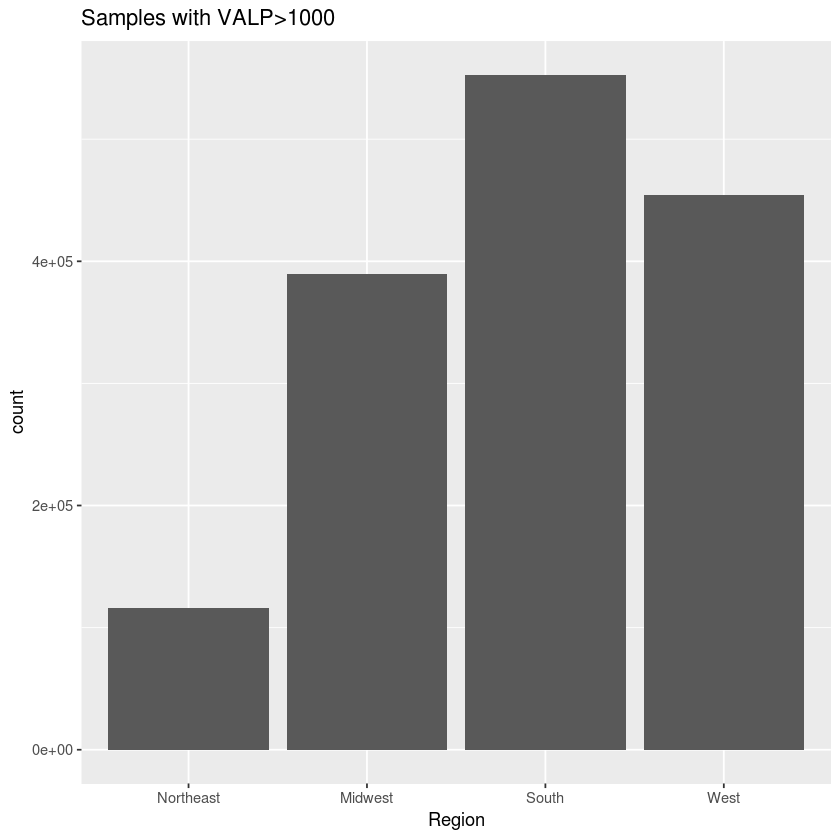

In [25]:
housing_valp_1000_bracket$REGION <- factor(
    x=housing_valp_1000_bracket$REGION, 
    levels=c(1,2,3,4,9),
    labels=c('Northeast', 'Midwest','South','West','Puerto Rico')
)
c <- ggplot(data=housing_region_df_local, aes(x=factor(REGION)))
c + geom_bar() + ggtitle("Samples with VALP>1000") + xlab("Region")

Finally, a function that is useful, specially when imputing missing values in data frames is [`isNaN`](https://spark.apache.org/docs/latest/api/R/isNaN.html) that can be applied to columns as we do with regular R data frames.

## Data aggregation and sorting

In the previous notebook we already had a look at `summary`/`describe` that we can pass column names and get summary statistics that way. If we want instead to be specific about the statistic we want, SparkR also defines the following aggregation functions that we can apply to `DataFrame` objects columns:  

- [`avg`](https://spark.apache.org/docs/latest/api/R/avg.html)    
- [`min`](https://spark.apache.org/docs/latest/api/R/min.html)    
- [`max`](https://spark.apache.org/docs/latest/api/R/max.html)   
- [`sum`](https://spark.apache.org/docs/latest/api/R/sum.html)  
- [`countDistinct`](https://spark.apache.org/docs/latest/api/R/countDistinct.html)  
- [`sumDistinct`](https://spark.apache.org/docs/latest/api/R/sumDistinct.html)  

We use them passing columns with the $ notation, and they return columns, so they need to be part of a `select` call for a `DataFrame`. For example.  

In [26]:
collect(select(housing_df, avg(housing_df$VALP)))

avg(VALP)
1 266797.8

### `groupBy` and `summarize`/`agg`

A basic operation when doing data aggregations on data frames is `groupBy`. Basically it groups the `DataFrame` we pass using the specified columns, so we can run aggregation on them. We use it in combination with `summarize`/`agg` in order to apply aggregation functions. For example, using the previous `avg` example, let's averagle property values by region as follows.

In [27]:
housing_avg_valp <- collect(agg(
    groupBy(housing_df, "REGION"), 
    NUM_PROPERTIES=n(housing_df$REGION),
    AVG_VALP = avg(housing_df$VALP), 
    MAX_VALUE=max(housing_df$VALP),
    MIN_VALUE=min(housing_df$VALP)
))
housing_avg_valp$REGION <- factor(
    housing_avg_valp$REGION, 
    levels=c(1,2,3,4,9), 
    labels=c('Northeast', 'Midwest','South','West','Puerto Rico')
)
housing_avg_valp

REGION    NUM_PROPERTIES AVG_VALP MAX_VALUE MIN_VALUE
1 Northeast 116206         364394.6 4532000   110      
2 South     552706         209776.2 3934000   100      
3 West      453920         413679.0 4727000   110      
4 Midwest   389298         172892.4 2267000   100

We can add as many summary/aggregation columns as functions we want to calculate. There is also the posibility of adding several levels of grouping. For example, let's add the number of bedrooms (`BDSP` in our [dictionary](http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict13.txt)) as follows.

In [28]:
housing_avg_valp <- collect(agg(
    groupBy(housing_df, "REGION", "BDSP"), 
    NUM_PROPERTIES=n(housing_df$REGION),
    AVG_VALP = avg(housing_df$VALP), 
    MAX_VALUE=max(housing_df$VALP),
    MIN_VALUE=min(housing_df$VALP)
))
housing_avg_valp$REGION <- factor(
    housing_avg_valp$REGION, 
    levels=c(1,2,3,4,9), 
    labels=c('Northeast', 'Midwest','South','West','Puerto Rico')
)
housing_avg_valp

REGION    BDSP NUM_PROPERTIES AVG_VALP  MAX_VALUE MIN_VALUE
1  West      10     2078         1163905.5 4727000      250   
2  Northeast  0     1992          283995.6 3224000    11600   
3  South      1    42034          127678.4 2880000      110   
4  Midwest    2    91884          115373.5 2267000      110   
5  Northeast  7      424         1505775.5 4532000      280   
6  West       7     1110          518111.6 3972000      160   
7  Midwest    3   147922          152142.5 2267000      100   
8  Northeast  2    27066          250627.5 4532000      120   
9  West       0    11640          252067.0 4727000      140   
10 Northeast NA    15710                NA      NA       NA   
11 Northeast  1    12162          238226.0 4532000      110   
12 West       9      396          513755.1 2386000      140   
13 Northeast  3    36904          309392.3 4532000      110   
14 South     NA    52562                NA      NA       NA   
15 South      5    11830          443907.9 3934000      140   
16 Midwest    5    13402          333356.2 2267000      110   
17 Northeast  4    17410          469747.1 4532000      110   
18 Midwest    9     2416          431554.5 2267000      150   
19 South      3   220636          175224.3 3934000      100   
20 Northeast  8      860          752145.0 3224000      200   
21 West       3   145286          369601.4 4727000      110   
22 Midwest    1    29972          100738.9 1571000      110   
23 Midwest    4    60920          237716.6 2267000      110   
24 West      NA    45118                NA      NA       NA   
25 West       6      194          716040.6 1923000      450   
26 South     14       38         1996615.4 3934000   320000   
27 South      6     5632          622725.0 3934000      140   
28 Midwest    0     4582          138400.9 1688000      120   
29 West      19       72          671500.0 1100000    65000   
30 Midwest   10      210          253336.5 1571000     2700   
31 South      2   131304          135066.2 3934000      100   
32 Northeast  5     3678          750904.0 4532000      140   
33 South      8     1180          726073.9 2738000      250   
34 South      4    79630          294095.2 3934000      110   
35 West       2   107240          288739.9 4727000      110   
36 West       4    73988          513162.1 4727000      110   
37 Midwest    8      342          342396.8 1420000      320   
38 Midwest   NA    37648                NA      NA       NA   
39 South      0     6542          135639.8 2518000      110   
40 West       1    49814          229137.8 4727000      110   
41 South      7     1318          506780.1 1945000      200   
42 West       5    16984          715636.0 4727000      120

### `arrange`

And finally, we can arrange a `DataFrame`.

In [29]:
head(arrange(select(housing_df, "REGION", "VALP"), desc(housing_df$VALP)))

REGION VALP   
1 4      4727000
2 4      4727000
3 4      4727000
4 4      4727000
5 4      4727000
6 4      4727000

Or our aggregations.

In [30]:
housing_avg_agg <- agg(
        groupBy(housing_df, "REGION", "BDSP"), 
        NUM_PROPERTIES=n(housing_df$REGION),
        AVG_VALP = avg(housing_df$VALP), 
        MAX_VALUE=max(housing_df$VALP),
        MIN_VALUE=min(housing_df$VALP)
    )
housing_avg_sorted <- head(arrange(housing_avg_agg, desc(housing_avg_agg$AVG_VALP)))

housing_avg_sorted$REGION <- factor(
    housing_avg_sorted$REGION, 
    levels=c(1,2,3,4,9), 
    labels=c('Northeast', 'Midwest','South','West','Puerto Rico')
)
housing_avg_sorted

REGION    BDSP NUM_PROPERTIES AVG_VALP  MAX_VALUE MIN_VALUE
1 South     14     38           1996615.4 3934000   320000   
2 Northeast  7    424           1505775.5 4532000      280   
3 West      10   2078           1163905.5 4727000      250   
4 Northeast  8    860            752145.0 3224000      200   
5 Northeast  5   3678            750904.0 4532000      140   
6 South      8   1180            726073.9 2738000      250

And that's it. In the next notebook we will dig deeper into property values using these operations and ggplot2 charts.